# Make spike pileup

In [35]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import cm
from matplotlib import colors
import matplotlib.patches as mpatches
import multiprocessing as mp
import matplotlib.image as image
from Bio import SeqIO, Seq
import gzip
import bz2
import seaborn as sns
from glob import glob
from matplotlib import ticker
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['figure.dpi']= 300

## Read data

In [2]:
datadir = 'pileups_indels/'

In [3]:
ampl_name = 'spike'

In [4]:
controls = {'SPIKE-RT-1-B_S10':'SPIKE-RT-EMPTY_S9', 'SPIKE-EVO-1-B_S12':'SPIKE-EVO-EMPTY_S11'}

In [5]:
raw_pileup_files = glob(os.path.join(datadir, 'SPIKE*_pileup.tsv'))
raw_pileup_files.sort()
raw_pileup_files = raw_pileup_files[::-1]
raw_pileup_data = {f.split('/')[-1].replace('_pileup.tsv', ''):pd.read_csv(f, sep='\t', index_col=0) for f in raw_pileup_files}

In [6]:
UMI_5_pileup_files = glob(os.path.join(datadir, 'SPIKE*_pileup_UMI_5.tsv'))
UMI_5_pileup_data = {f.split('/')[-1].replace('_pileup_UMI_5.tsv', ''):pd.read_csv(f, sep='\t', index_col=0) for f in UMI_5_pileup_files}

## Read amplicons

In [7]:
basedir = './'

In [8]:
spike = str([rec.seq for rec in SeqIO.parse(os.path.join(basedir, 'amplicons/spike.fasta'), 'fasta')][0])
EGFP = str([rec.seq for rec in SeqIO.parse(os.path.join(basedir, 'amplicons/EGFP.fasta'), 'fasta')][0])

EGFP_F_S = 'CGAGCTGAAGGGCATCGAC'
EGFP_R_S = 'CTCGTCCATGCCGAGAGTGA'
EGFP_amplicon_S = EGFP[EGFP.find(EGFP_F_S):EGFP.find(str(Seq.Seq(EGFP_R_S).reverse_complement()))+len(EGFP_R_S)]

spike_F_S = 'TGCCATCGGCAAGATTCAAG'
spike_R_S = 'TGCCACAAAAGTCGACCCG'
spike_amplicon_S = spike[spike.find(spike_F_S):spike.find(str(Seq.Seq(spike_R_S).reverse_complement()))+len(spike_R_S)]

ampls = {'GFP':EGFP, 'spike':spike}

In [9]:
ampl_coords = {'GFP':(EGFP.find(EGFP_amplicon_S), EGFP.find(EGFP_amplicon_S)+len(EGFP_amplicon_S)),
    'spike':(spike.find(spike_amplicon_S), spike.find(spike_amplicon_S)+len(spike_amplicon_S))}

In [10]:
ampl_coords

{'GFP': (371, 708), 'spike': (2786, 3133)}

## Guides

In [11]:
guide_seq = {'GFP':{'B':'caacgagaagcgcgatcaca', '1':'gagcTaagaccccaacgaga'},
             'spike':{'1':'CGACCCACCGGAAGCAGAAG', 'B':'CAAATTGATCGCCTGATAAC'}}

In [12]:
guide_pos = {ampl:{g:ampls[ampl].find(guide_seq[ampl][g].upper()) for g in guide_seq[ampl]} for ampl in guide_seq}

In [13]:
guide_pos

{'GFP': {'B': 635, '1': 623}, 'spike': {'1': 2951, 'B': 2973}}

In [14]:
guides_by_sample = {
    'GFP-EMPTY_S1':[],
    'GFP-1_S2':['1'],
    'GFP-1-B_S3':['1', 'B'],
    'SPIKE-RT-EMPTY_S9':[],
    'SPIKE-RT-1-B_S10':['1', 'B'],
    'SPIKE-EVO-EMPTY_S11':[],
    'SPIKE-EVO-1-B_S12':['1', 'B']
}

In [15]:
nick_sites = {s:{g:guide_pos[ampl_name][g]+2.5 if g!='B' else guide_pos[ampl_name][g]+16.5 for g in guides_by_sample[s]}
              for s in raw_pileup_data}

## Make pileups

In [16]:
def make_af_to_plot(pileup):
    af_to_plot = {'pos':[], 'A':[], 'C':[], 'G':[], 'T':[]}
    for i in pileup.index:
        for b in ['A', 'C', 'G', 'T']:
            if b != pileup.loc[i, 'ref'] and pileup.loc[i, 'cov']>1e4:
                af_to_plot[b].append(pileup.loc[i, b]/pileup.loc[i, 'cov'])
            else:
                af_to_plot[b].append(0.0)
        af_to_plot['pos'].append(pileup.loc[i, 'pos'])
    return pd.DataFrame(af_to_plot).fillna(0)

In [17]:
upstream_window = 5
downstream_window = 20

In [18]:
titles = {
    'SPIKE-RT-EMPTY_S9':'HIV-1 RT + non-targeting sgRNAs',
    'SPIKE-RT-1-B_S10': 'HIV-1 RT + targeting sgRNAs',
    'SPIKE-EVO-EMPTY_S11': 'Polλ Δ2 R438W + non-targeting sgRNAs',
    'SPIKE-EVO-1-B_S12': 'Polλ Δ2 R438W + targeting sgRNAs'
}

### Raw data pileups

In [19]:
af_to_plot = {f:make_af_to_plot(raw_pileup_data[f]) for f in raw_pileup_data}

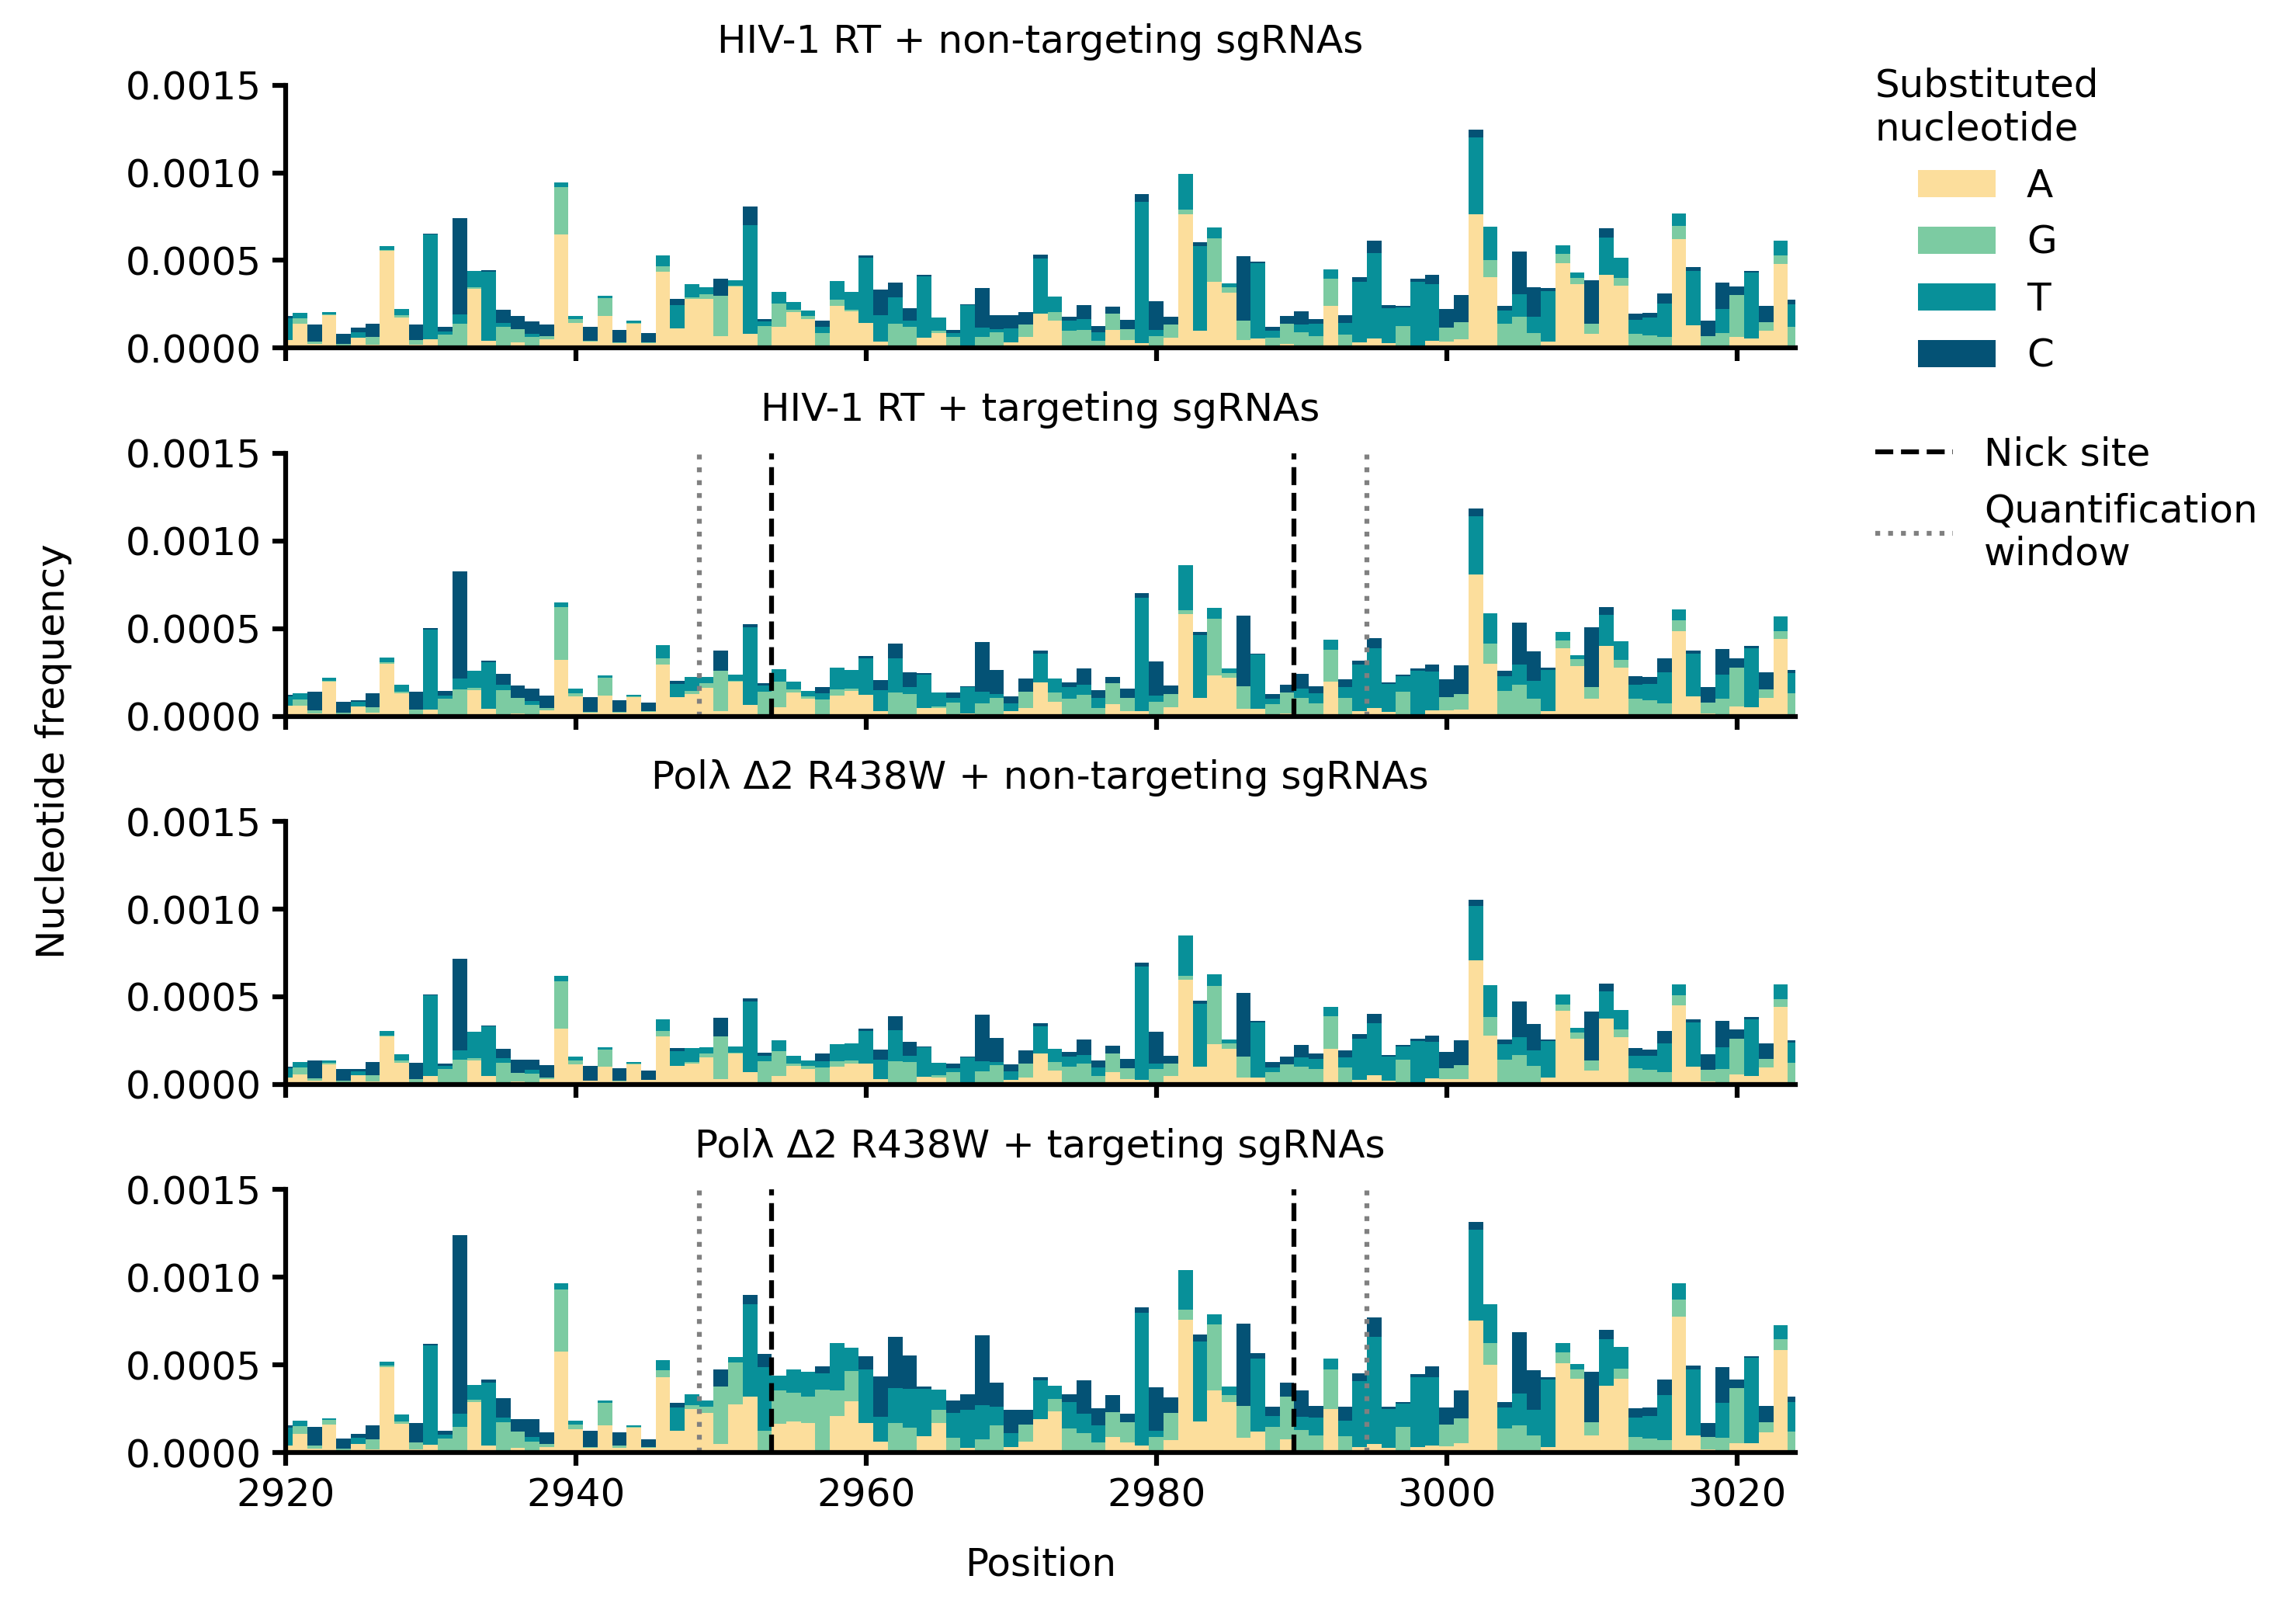

In [22]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 7), sharex=True)

for n,f in enumerate(raw_pileup_data):
    af_to_plot[f][['A', 'G', 'T', 'C']].plot(kind='bar', stacked=True, ax=ax[n], legend=False, width=1,
                                             #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
                                             color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
                                             #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
    ymax = 0.0015
    ax[n].set_ylim(0, ymax)
    ax[n].set_xlim(2954-34, 2990+34)
    ax[n].set_xticks([i for i in range(2954-34, 2990+34, 20)])
    ax[n].set_xticklabels([i for i in range(2954-34, 2990+34, 20)], size=12, rotation=0)
    ax[n].set_yticks([0,0.5e-3, 1e-3, 1.5e-3])
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(titles[f], size=12, pad=10)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    ax[n].set_ylabel('N', size=12, labelpad=20, color='white')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        nick_l = ax[n].vlines(nick, 0, ymax, color='k', linestyle='--', label='Nick site')
        if 'B' not in guide_names:
            ax[n].vlines(nick-upstream_window, 0, ymax, color='gray', linestyle='dotted')
            ax[n].vlines(nick+downstream_window, 0, ymax, color='gray', linestyle='dotted')
        else:
            if guide_name=='B':
                qw_l = ax[n].vlines(nick+upstream_window, 0, ymax, color='gray', linestyle='dotted', label='Quantification\nwindow')
            else:
                ax[n].vlines(nick-upstream_window, 0, ymax, color='gray', linestyle='dotted')

lgd = ax[0].legend(loc='upper left', bbox_to_anchor=(1.03, 1.2),
                title ='Substituted\nnucleotide', prop={'size':12}, ncol=1, frameon=False)
plt.setp(lgd.get_title(),fontsize='12')

ax[1].legend(handles = [nick_l, qw_l], loc='upper left', bbox_to_anchor=(1.03, 1.2), prop={'size':12}, ncol=1, frameon=False)

ax[-1].set_xlabel('Position', size=12, labelpad=10)   
plt.tight_layout()
plt.text(2904, 0.004, 'Nucleotide frequency', size=12, horizontalalignment='center', verticalalignment='center', rotation='vertical')
plt.subplots_adjust(hspace=0.4)
plt.show()

## UMI-corrected pileup

In [20]:
af_to_plot = {f:make_af_to_plot(UMI_5_pileup_data[f]) for f in UMI_5_pileup_data}

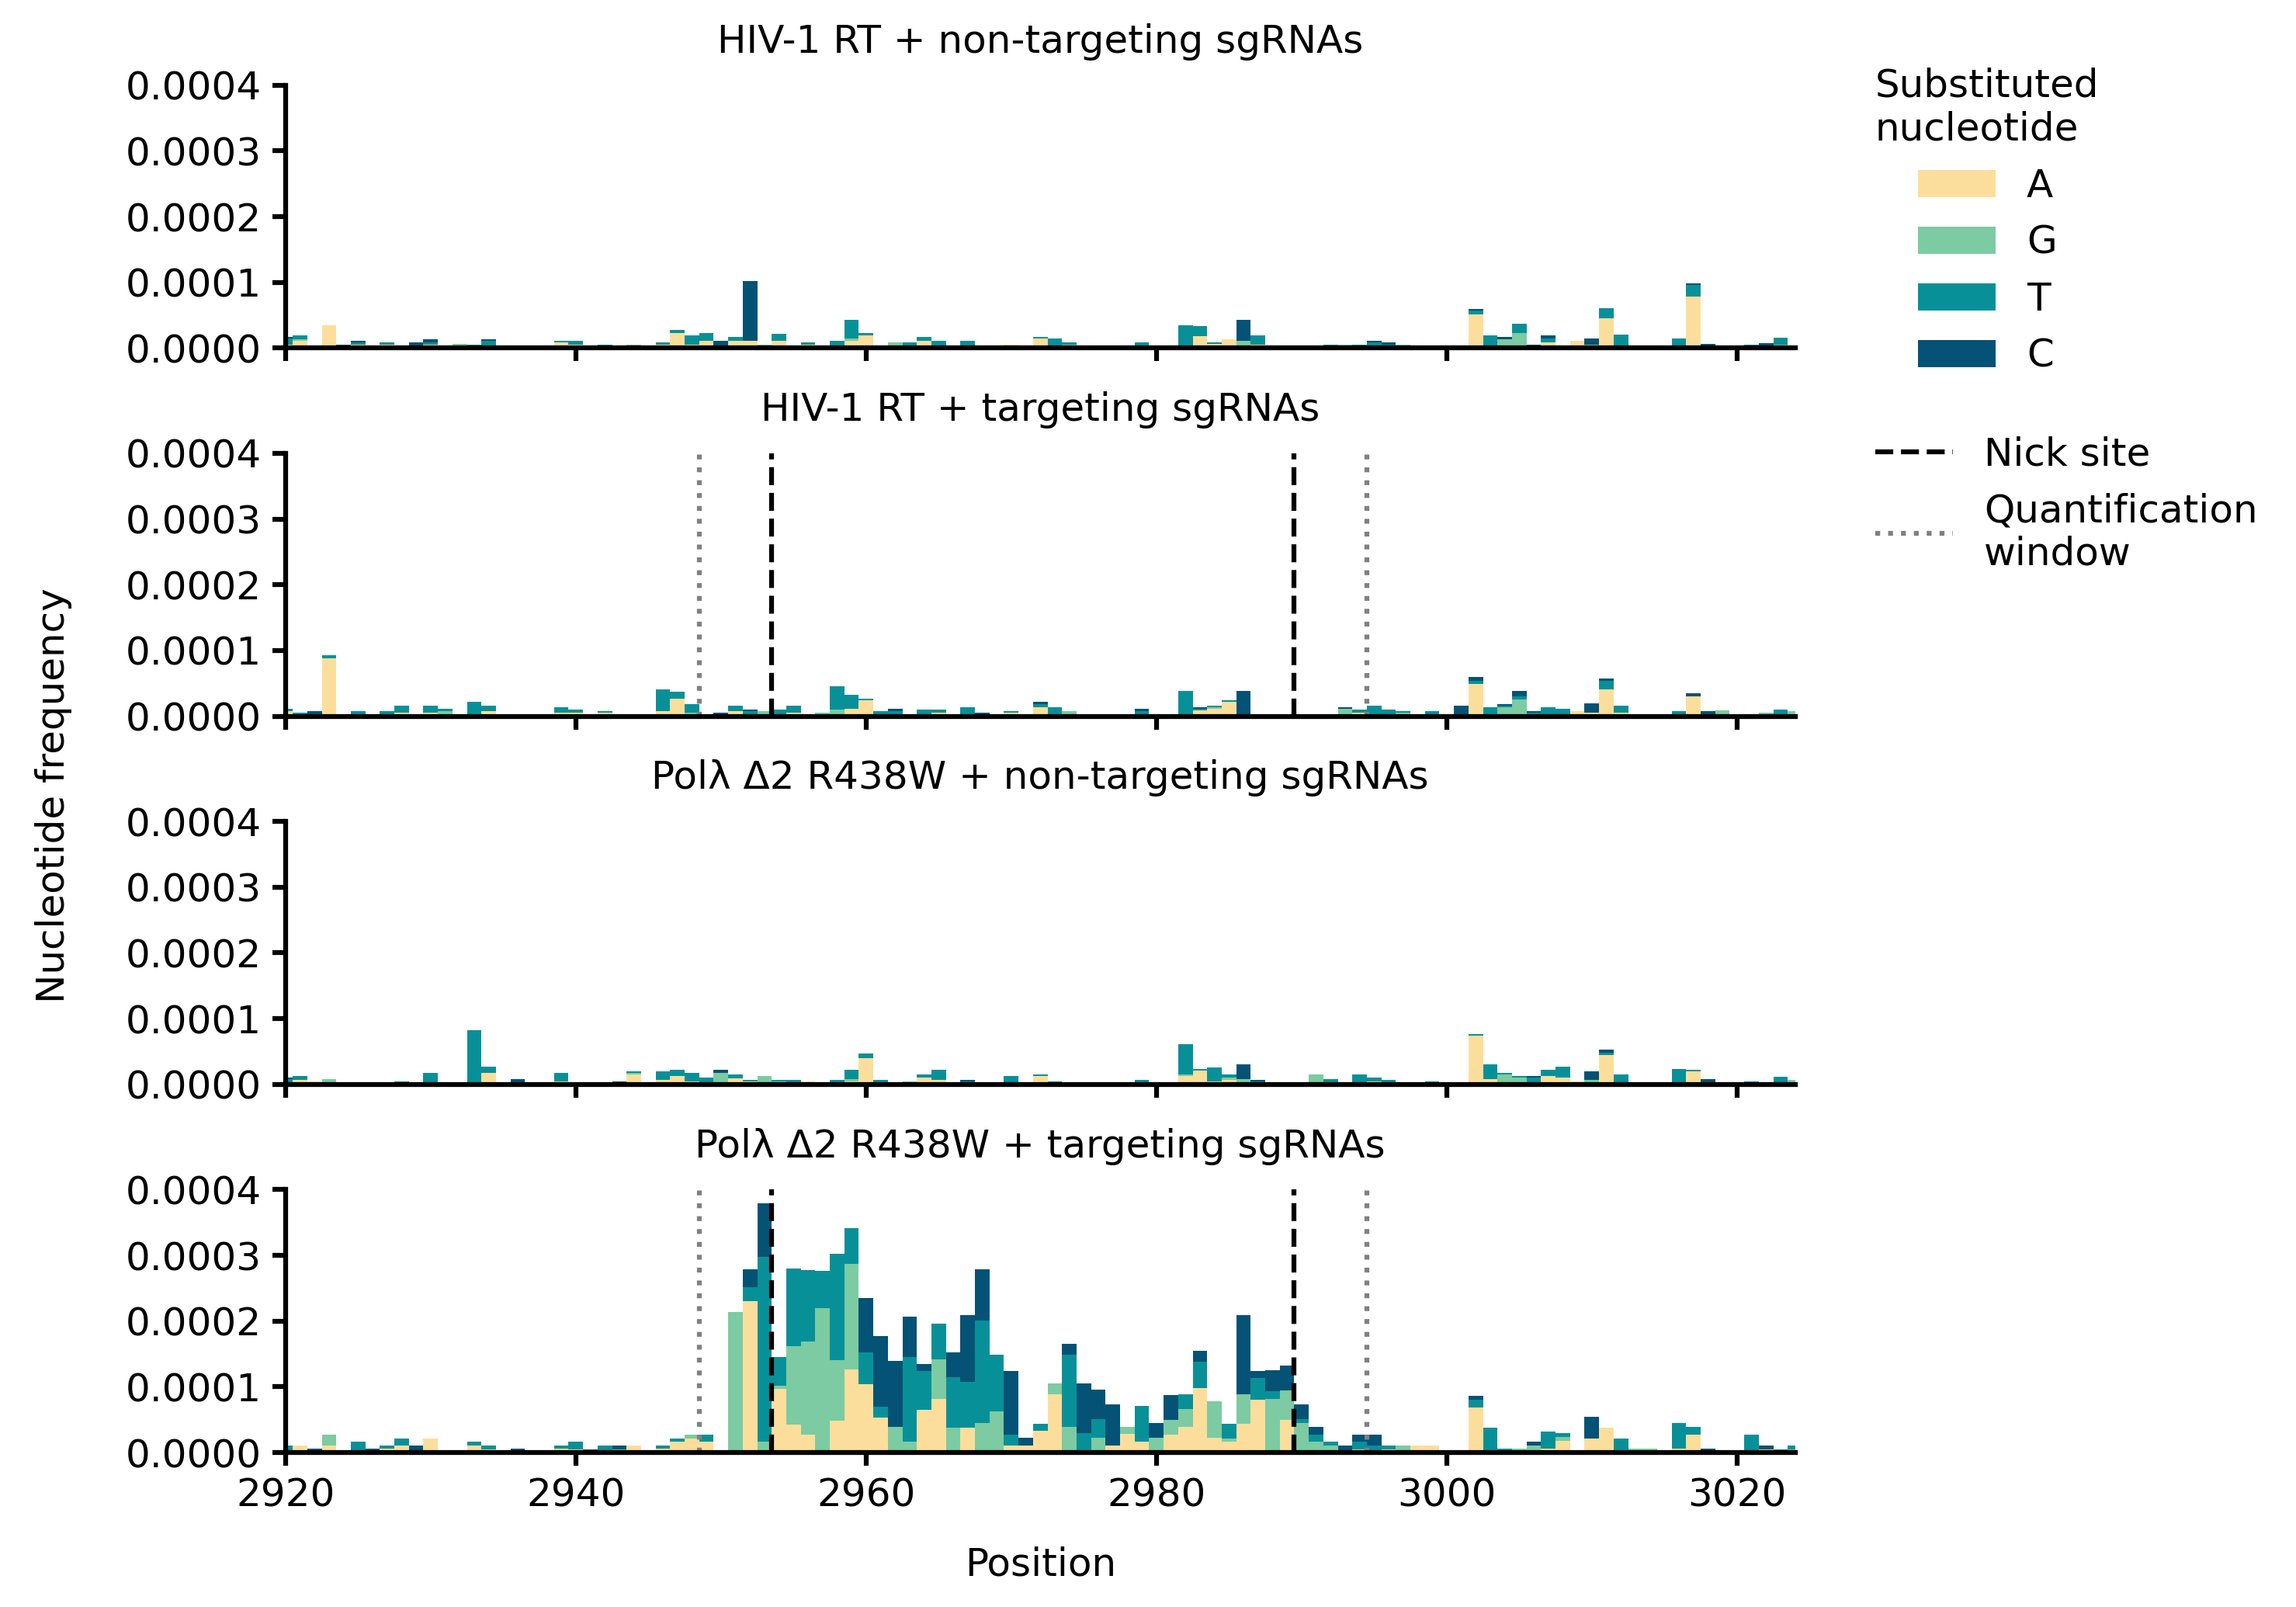

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 7), sharex=True)

for n,f in enumerate(raw_pileup_data):
    af_to_plot[f][['A', 'G', 'T', 'C']].plot(kind='bar', stacked=True, ax=ax[n], legend=False, width=1,
                                             #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
                                             color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
                                             #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
    ymax = 0.0004
    ax[n].set_ylim(0, ymax)
    ax[n].set_xlim(2954-34, 2990+34)
    ax[n].set_xticks([i for i in range(2954-34, 2990+34, 20)])
    ax[n].set_xticklabels([i for i in range(2954-34, 2990+34, 20)], size=12, rotation=0)
    ax[n].set_yticks([0, 1e-4, 2e-4, 3e-4, 4e-4])
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(titles[f], size=12, pad=10)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    ax[n].set_ylabel('N', size=12, labelpad=20, color='white')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        nick_l = ax[n].vlines(nick, 0, ymax, color='k', linestyle='--', label='Nick site')
        if 'B' not in guide_names:
            ax[n].vlines(nick-upstream_window, 0, ymax, color='gray', linestyle='dotted')
            ax[n].vlines(nick+downstream_window, 0, ymax, color='gray', linestyle='dotted')
        else:
            if guide_name=='B':
                qw_l = ax[n].vlines(nick+upstream_window, 0, ymax, color='gray', linestyle='dotted', label='Quantification\nwindow')
            else:
                ax[n].vlines(nick-upstream_window, 0, ymax, color='gray', linestyle='dotted')

lgd = ax[0].legend(loc='upper left', bbox_to_anchor=(1.03, 1.2),
                title ='Substituted\nnucleotide', prop={'size':12}, ncol=1, frameon=False)
plt.setp(lgd.get_title(),fontsize='12')

ax[1].legend(handles = [nick_l, qw_l], loc='upper left', bbox_to_anchor=(1.03, 1.2), prop={'size':12}, ncol=1, frameon=False)
ax[-1].set_xlabel('Position', size=12, labelpad=10)   
plt.tight_layout()
plt.text(2904, 0.001, 'Nucleotide frequency', size=12, horizontalalignment='center', verticalalignment='center', rotation='vertical')
plt.subplots_adjust(hspace=0.4)
plt.show()

## Boxplot

In [21]:
data_by_UMI_depth = {1:raw_pileup_data, 5:UMI_5_pileup_data}

In [22]:
UMI_depth = 5

In [23]:
upstream_window = 5

In [24]:
data_in_window = {'1+B':{}}
for f in raw_pileup_data:
    nick_1 = int(nick_sites['SPIKE-EVO-1-B_S12']['1']+0.5)
    nick_B = int(nick_sites['SPIKE-EVO-1-B_S12']['B']+0.5)
    data_in_window['1+B'][f] = data_by_UMI_depth[UMI_depth][f][
        nick_1-upstream_window:nick_B+upstream_window]['af']

In [25]:
nick_B+upstream_window - (nick_1-upstream_window)

46

In [26]:
data_by_UMI_depth[UMI_depth].keys()

dict_keys(['SPIKE-EVO-EMPTY_S11', 'SPIKE-EVO-1-B_S12', 'SPIKE-RT-1-B_S10', 'SPIKE-RT-EMPTY_S9'])

In [27]:
data_in_window = {g:pd.DataFrame(data_in_window[g]) for g in data_in_window}

In [28]:
data_in_window['1+B'].shape[0]

46

In [29]:
data_in_window_reshaped = pd.concat([data_in_window[g].melt().assign(guide=[g]*data_in_window[g].melt().shape[0]) for g in data_in_window])

In [30]:
data_in_window_reshaped.columns = ['Sample', 'AF', 'Guide']

In [31]:
data_in_window_reshaped.to_csv('SPIKE_pileup_AF_melted.tsv', sep='\t', index=False)

In [32]:
colors_bxp = {
    'SPIKE-RT-EMPTY_S9':'#fcde9c',
    'SPIKE-RT-1-B_S10':'#7ccba2',
    'SPIKE-EVO-EMPTY_S11':'#089099',
    'SPIKE-EVO-1-B_S12':'#045275'
}

In [69]:
colors_bxp = {
    'SPIKE-RT-EMPTY_S9':'#fcde9c',
    'SPIKE-RT-1-B_S10':'#f0746e',
    'SPIKE-EVO-EMPTY_S11':'#dc3977',
    'SPIKE-EVO-1-B_S12':'#7c1d6f'
}

In [33]:
titles_1 = {'SPIKE-RT-EMPTY_S9': 'HIV-1 RT +\nnon-targeting sgRNAs',
 'SPIKE-RT-1-B_S10': 'HIV-1 RT +\ntargeting sgRNAs',
 'SPIKE-EVO-EMPTY_S11': 'Polλ Δ2 R438W +\nnon-targeting sgRNAs',
 'SPIKE-EVO-1-B_S12': 'Polλ Δ2 R438W +\ntargeting sgRNAs'}

titles_2 = {'SPIKE-RT-EMPTY_S9': 'Pol RT + NT sgRNAs',
 'SPIKE-RT-1-B_S10': 'Pol RT +\ntargeting sgRNAs',
 'SPIKE-EVO-EMPTY_S11': 'Polλ Δ2 R438W +\nnon-targeting sgRNAs',
 'SPIKE-EVO-1-B_S12': 'Polλ Δ2 R438W +\ntargeting sgRNAs'}

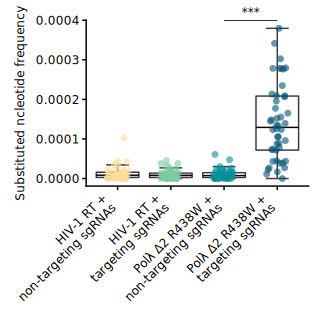

In [52]:
guide = '1+B'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), sharey=True)

data = data_in_window[guide]
sns.boxplot(data=data, ax=ax, color='white', flierprops={'alpha':0}, medianprops={'color':'k'}, linewidth=1.5)
sns.stripplot(data=data, ax=ax, palette=colors_bxp, alpha=0.6, jitter=0.2, size=7)
sns.despine()
ax.set_title('Guide {}'.format(guide))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([titles_1[x] for x in data.columns])
#ax.set_yscale('symlog', linthresh=1e-4)
ax.set_ylim(top=4e-4)
ax.set_title('')
for x in ax.get_xticklabels():
    x.set_rotation(45)
    x.set_ha('right')
    x.set_size(12)
    
for y in ax.get_yticklabels():
    y.set_size(12)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(width=1.5, length=4)
ax.set_ylabel('Substituted ncleotide frequency', size=12, labelpad=10)

plt.show()

In [53]:
data_in_window_reshaped.groupby(['Sample', 'Guide'])['AF'].mean()

Sample               Guide
SPIKE-EVO-1-B_S12    1+B      0.000141
SPIKE-EVO-EMPTY_S11  1+B      0.000010
SPIKE-RT-1-B_S10     1+B      0.000010
SPIKE-RT-EMPTY_S9    1+B      0.000012
Name: AF, dtype: float64

## Base substitution plot

In [54]:
window_start = int(nick_sites['SPIKE-EVO-1-B_S12']['1']+0.5) - upstream_window
window_end = int(nick_sites['SPIKE-EVO-1-B_S12']['B']+0.5) + upstream_window
alt_base_count = {}
bases = ['A', 'G', 'T', 'C']
for f in UMI_5_pileup_data:
    alt_base_count[f] = {'og_'+b:{b2:0 for b2 in bases if b2!=b} for b in bases}
    for i in range(window_start, window_end):
            ref = UMI_5_pileup_data[f].loc[i, 'ref']
            for b in bases:
                if b!=ref:
                    alt_base_count[f]['og_'+ref][b] += UMI_5_pileup_data[f].loc[i, b]

In [55]:
alt_base_count = {f:pd.DataFrame(alt_base_count[f]).transpose().fillna(0)[
    ['A', 'G', 'T', 'C']] for f in alt_base_count}

In [56]:
alt_base_count['SPIKE-EVO-1-B_S12'].sum().sum()

1185.0

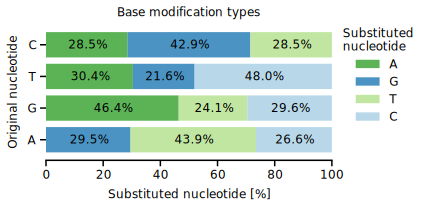

In [70]:
name = 'SPIKE-EVO-1-B_S12'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
perc = alt_base_count[name].divide(alt_base_count[name].sum(axis=1), axis=0).multiply(100)
perc_cumsum = perc.apply(np.cumsum, axis=1)

ax = perc.plot(kind='barh', stacked=True, width=0.8, ax=ax, legend=False, alpha=0.8,
               #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
               #color = ['#80cdc1', '#018571', '#dfc27d', '#a6611a']) # orange and green
               color = ['#33a02c', '#1f78b4', '#b2df8a', '#a6cee3']) # blue and green
               #color = ['#fdb863', '#e66101', '#b2abd2', '#5e3c99']) # orange and purple
               #color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
               #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
ax.set_title('Base modification types', size=12, pad=8)
ax.set_xlabel('Substituted nucleotide [%]', size=12, labelpad=8)

lgd = ax.legend(loc='upper left', bbox_to_anchor=(1, 1.05), frameon=False,
                title ='Substituted\nnucleotide', prop={'size':12}, ncol=1)
plt.setp(lgd.get_title(),fontsize='12')
ax.set_yticklabels([y.split('_')[1] for y in perc.index])

for y in ax.get_yticklabels():
    y.set_size(12)
for x in ax.get_xticklabels():
    x.set_size(12)
    x.set_rotation(0)
    
for jy,j in enumerate(perc.index):
    for ix,i in enumerate(perc.columns):
        if perc.loc[j, i]>0:
            x_base = perc_cumsum.loc[j].iloc[ix-1] if ix>0 else 0
            x = (perc_cumsum.loc[j, i]+x_base)/2
            ax.text(x-6.5, jy-0.12, '{:.1f}%'.format(perc.loc[j, i]), color='k',
                   size=12)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)

#ax.tick_params(axis='y', which='major', pad=80)
#ax.tick_params(left=False)
ax.tick_params(width=1.5, length=6)
    
ax.set_xlim(0,100)    
ax.set_ylabel('Original nucleotide', size=12, labelpad=8)
plt.tight_layout()
plt.show()
#plt.savefig('Figures/'+name+'_base_modification_types.svg')

## Indel reads pileup

In [57]:
indel_pileup_files = glob(os.path.join(datadir, 'SPIKE*_pileup_indel_reads.tsv'))
indel_pileup_files.sort()
indel_pileup_files = indel_pileup_files[::-1]
indel_pileup_data = {f.split('/')[-1].replace('_pileup_indel_reads.tsv', ''):pd.read_csv(f, sep='\t', index_col=0) for f in indel_pileup_files}

In [58]:
def make_af_to_plot(pileup):
    af_to_plot = {'pos':[], 'A':[], 'C':[], 'G':[], 'T':[]}
    for i in pileup.index:
        for b in ['A', 'C', 'G', 'T']:
            if b != pileup.loc[i, 'ref'] and pileup.loc[i, 'cov']>1e2:
                af_to_plot[b].append(pileup.loc[i, b]/pileup.loc[i, 'cov'])
            else:
                af_to_plot[b].append(0.0)
        af_to_plot['pos'].append(pileup.loc[i, 'pos'])
    return pd.DataFrame(af_to_plot).fillna(0)

In [59]:
af_to_plot = {f:make_af_to_plot(indel_pileup_data[f]) for f in indel_pileup_data}

In [60]:
titles = {
    'SPIKE-RT-EMPTY_S9':'HIV-1 RT + non-targeting sgRNAs',
    'SPIKE-RT-1-B_S10': 'HIV-1 RT + targeting sgRNAs',
    'SPIKE-EVO-EMPTY_S11': 'Polλ Δ2 R438W + non-targeting sgRNAs',
    'SPIKE-EVO-1-B_S12': 'Polλ Δ2 R438W + targeting sgRNAs'
}

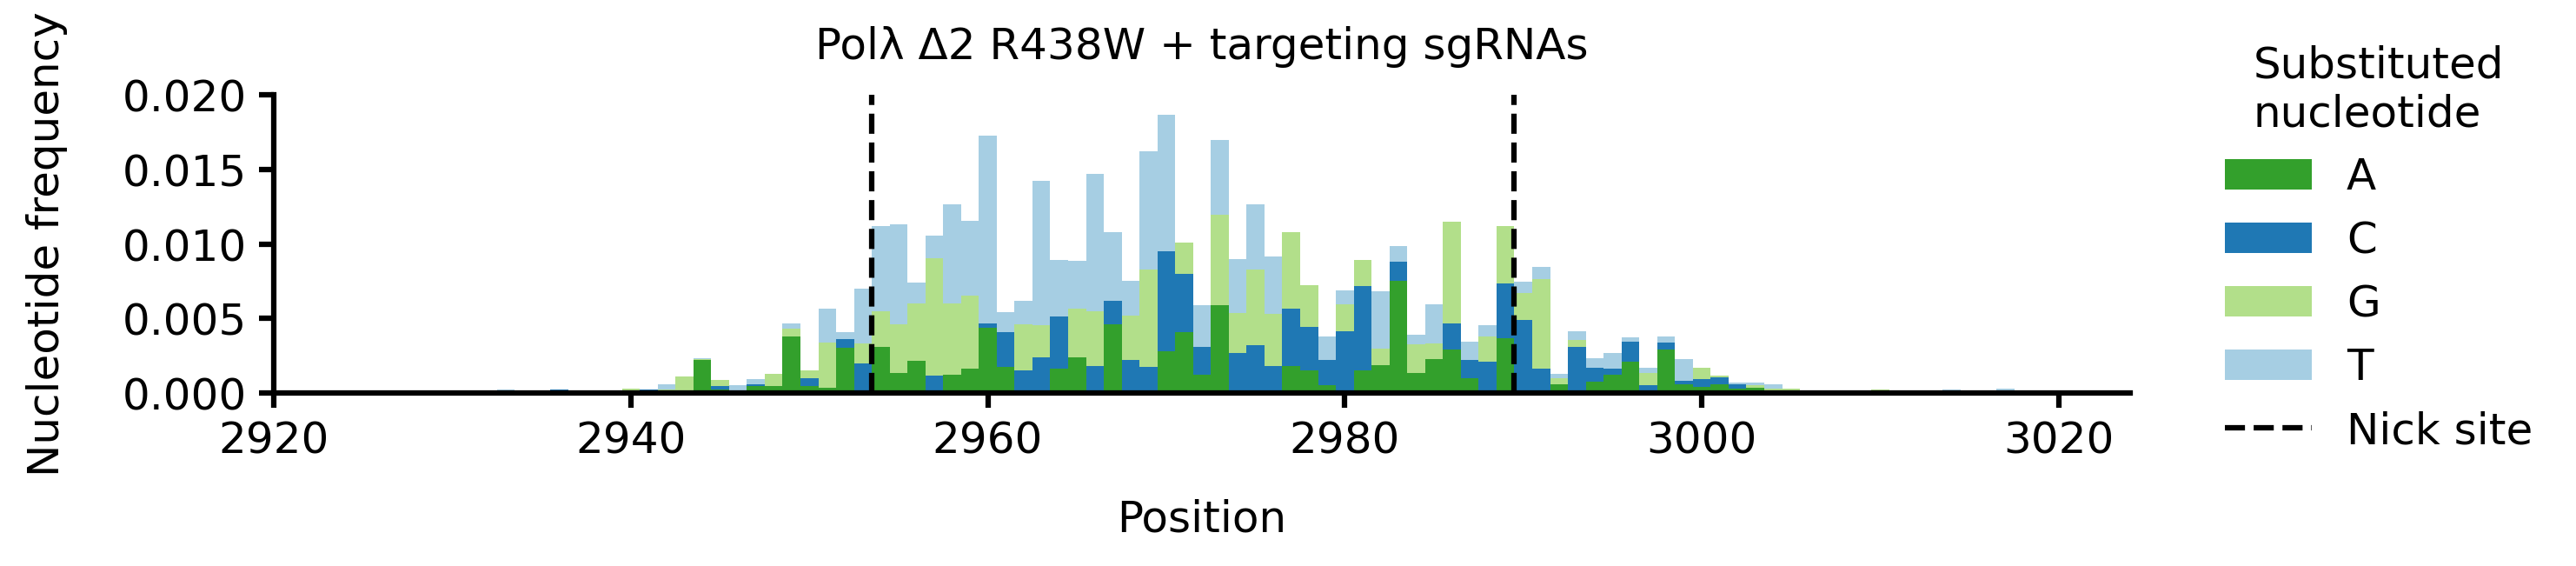

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 2.5))

for n,f in enumerate(['SPIKE-EVO-1-B_S12']):
    af_to_plot[f][['A', 'C', 'G', 'T']].plot(kind='bar', stacked=True, ax=ax, legend=False, width=1,
                                             #color = ['#f8766d', '#7cae00', '#00bfc4','#c77cff']) original
                                             #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
                                             color = ['#33a02c', '#1f78b4', '#b2df8a', '#a6cee3']) # green and blue
                                             #color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
                                             #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
    ymax = {'SPIKE-EVO-1-B_S12':0.02}
    ax.set_ylim(0, ymax[f])
    ax.set_xlim(2954-34, 2990+34)
    ax.set_xticks([i for i in range(2954-34, 2990+34, 20)])
    ax.set_xticklabels([i for i in range(2954-34, 2990+34, 20)], size=12, rotation=0)
    for y in ax.get_yticklabels():
        y.set_size(12)
    ax.set_title(titles[f], size=12, pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.tick_params(width=1.5, length=4)
    ax.set_ylabel('Nucleotide frequency', size=12, labelpad=15, color='k')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        if guide_name=='B':
            nick_l = ax.vlines(nick, 0, ymax[f], color='k', linestyle='--', label='Nick site')
        else:
            ax.vlines(nick, 0, ymax[f], color='k', linestyle='--')
        # if 'B' not in guide_names:
        #     ax.vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        #     ax.vlines(nick+downstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        # else:
        #     if guide_name=='B':
        #         qw_l = ax.vlines(nick+upstream_window, 0, ymax[f], color='gray', linestyle='dotted', label='Quantification\nwindow')
        #     else:
        #         ax.vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,4,0]
lgd = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', bbox_to_anchor=(1.03, 1.3),
                frameon=False, title ='Substituted\nnucleotide', prop={'size':12}, ncol=1)
plt.setp(lgd.get_title(),fontsize='12')
ax.set_xlabel('Position', size=12, labelpad=10)
    
plt.tight_layout()
plt.show()

## Make Fig. 4

In [61]:
datadir = '/shares/CIBIO-Storage/CM/scratch/users/matteo.ciciani/NGS/Federica_Aug_2023/pileups_indels/'

ampl_name = 'spike'

indel_counts = pd.read_csv(os.path.join(datadir, '{}_indel_read_counts_UMI_5.tsv'.format(ampl_name)), sep='\t', index_col=0)
indel_counts

,Insertions,Deletions
SPIKE-RT-EMPTY_S9,0,1
SPIKE-RT-1-B_S10,0,0
SPIKE-EVO-EMPTY_S11,0,0
SPIKE-EVO-1-B_S12,36530,100037


In [62]:
insertion_files = glob(os.path.join(datadir, 'SPIKE*_insertions_by_UMI_5.tsv.bz2'))
insertion_files.sort()
insertion_files = insertion_files[::-1]

insertion_data = {f.split('/')[-1].replace('_insertions_by_UMI_5.tsv.bz2', ''):pd.read_csv(bz2.open(f, 'rt'), sep='\t', index_col=0)
                 for f in insertion_files}

In [63]:
deletion_files = glob(os.path.join(datadir, 'SPIKE*_deletions_by_UMI_5.tsv.bz2'))
deletion_files.sort()
deletion_files = deletion_files[::-1]

deletion_data = {f.split('/')[-1].replace('_deletions_by_UMI_5.tsv.bz2', ''):pd.read_csv(bz2.open(f, 'rt'), sep='\t', index_col=0)
                 for f in deletion_files}

In [64]:
insertion_data = {f:insertion_data[f]['0'].apply(eval) for f in insertion_data}
deletion_data = {f:deletion_data[f]['0'].apply(eval) for f in deletion_data}

In [65]:
UMI_counts = pd.read_csv('UMI_indel_ratio.tsv', sep='\t', index_col=0)

In [66]:
deletion_data_counts = {}
for f in deletion_data:
    deletion_data_counts[f] = []
    for pos in deletion_data[f].index:
        for UMI in deletion_data[f].loc[pos]:
            for i in range(pos, pos+deletion_data[f].loc[pos][UMI]):
                deletion_data_counts[f].append(i)

deletion_data_counts = {f:pd.Series(Counter(deletion_data_counts[f])) for f in deletion_data_counts}
for f in deletion_data_counts:
    for i in range(*ampl_coords[ampl_name]):
        if i not in deletion_data_counts[f].index:
            deletion_data_counts[f].loc[i] = 0
deletion_data_counts = {f:deletion_data_counts[f].sort_index() for f in deletion_data_counts}

In [67]:
control = 'SPIKE-EVO-EMPTY_S11'

In [68]:
indel_window = 20

In [69]:
nick_sites = {f:{g:int(nick_sites[f][g]+0.5) for g in nick_sites[f]} for f in nick_sites}

In [70]:
nick_sites

{'SPIKE-RT-EMPTY_S9': {},
 'SPIKE-RT-1-B_S10': {'1': 2954, 'B': 2990},
 'SPIKE-EVO-EMPTY_S11': {},
 'SPIKE-EVO-1-B_S12': {'1': 2954, 'B': 2990}}

In [71]:
insertions_in_window = {g:{} for g in ['1+B']}
deletions_in_window = {g:{} for g in ['1+B']}
for f in insertion_data:
    for g in insertions_in_window:
        insertions_in_window[g][control] = set(np.unique([UMI for pos_data in insertion_data[control][
            nick_sites['SPIKE-EVO-1-B_S12']['1']-indel_window:nick_sites['SPIKE-EVO-1-B_S12']['B']+indel_window].values for UMI in pos_data]))
        insertions_in_window[g][f] = set(np.unique([UMI for pos_data in insertion_data[f][
            nick_sites['SPIKE-EVO-1-B_S12']['1']-indel_window:nick_sites['SPIKE-EVO-1-B_S12']['B']+indel_window].values for UMI in pos_data]))

        deletions_in_window[g][control] = set(np.unique([UMI for pos in deletion_data[control].index
            for UMI in deletion_data[control].loc[pos] if pos<nick_sites['SPIKE-EVO-1-B_S12']['B']+indel_window and pos+deletion_data[
                control].loc[pos][UMI]>nick_sites['SPIKE-EVO-1-B_S12']['1']-indel_window]))
        deletions_in_window[g][f] = set(np.unique([UMI for pos in deletion_data[f].index for UMI in deletion_data[f].loc[pos]
            if pos<nick_sites['SPIKE-EVO-1-B_S12']['B']+indel_window and pos+deletion_data[
                                                   f].loc[pos][UMI]>nick_sites['SPIKE-EVO-1-B_S12']['1']-indel_window]))

In [72]:
indel_in_window_UMIs = {g:{f:[UMI for UMI in insertions_in_window[g][f] if UMI in deletions_in_window[g][f]]
                               for f in insertions_in_window[g]} for g in insertions_in_window}
insertions_in_window_UMIs = {g:{f:[UMI for UMI in insertions_in_window[g][f] if UMI not in deletions_in_window[g][f]]
                               for f in insertions_in_window[g]} for g in insertions_in_window}
deletions_in_window_UMIs = {g:{f:[UMI for UMI in deletions_in_window[g][f] if UMI not in insertions_in_window[g][f]]
                               for f in insertions_in_window[g]} for g in insertions_in_window}

In [73]:
indel_in_window_fraction = {g:{f:len([UMI for UMI in insertions_in_window[g][f] if UMI in deletions_in_window[g][f]])/UMI_counts.loc[f, 'Total']
                               for f in insertions_in_window[g]} for g in insertions_in_window}
insertions_in_window_fraction = {g:{f:len([UMI for UMI in insertions_in_window[g][f] if UMI not in deletions_in_window[g][f]])/UMI_counts.loc[f, 'Total']
                               for f in insertions_in_window[g]} for g in insertions_in_window}
deletions_in_window_fraction = {g:{f:len([UMI for UMI in deletions_in_window[g][f] if UMI not in insertions_in_window[g][f]])/UMI_counts.loc[f, 'Total']
                               for f in insertions_in_window[g]} for g in insertions_in_window}

In [74]:
indel_fract = {g:{f:pd.Series([deletions_in_window_fraction[g][f], insertions_in_window_fraction[g][f], indel_in_window_fraction[g][f]],
    index=['Deletions', 'Insertions', 'Insertions and\nDeletions']) for f in insertions_in_window_fraction[g]} 
    for g in insertions_in_window_fraction}

In [75]:
for g in indel_fract:
    for f in indel_fract[g]:
        indel_fract[g][f]['No Indels'] = 1-indel_fract[g][f].sum()

In [76]:
indel_fract_dfs = {g:pd.DataFrame(indel_fract[g]) for g in indel_fract}

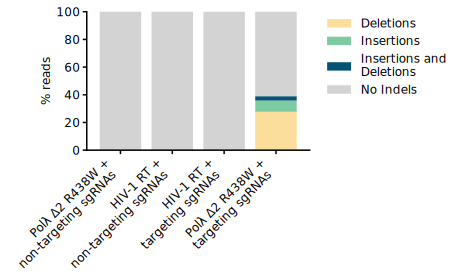

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2.5))


indel_fract_dfs['1+B'].transpose().multiply(100).plot(kind='bar', stacked=True, legend=False, ax=ax, width=0.8,
                                        color = ['lightgray', '#045275', '#7ccba2', '#fcde9c'][::-1])

ax.set_xticklabels([titles[x.get_text()].replace('+', '+\n') for x in ax.get_xticklabels()], rotation = 45, ha='right', size=12)
ax.set_ylabel('% reads', size=12)
lgd = ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.03), frameon=False, title ='', prop={'size':12}, ncol=1)

ax.set_ylim(0,100)
for y in ax.get_yticklabels():
    y.set_size(12)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(width=1.5, length=4)

plt.show()

In [62]:
indel_fract_dfs['1+B']

,SPIKE-EVO-EMPTY_S11,SPIKE-RT-EMPTY_S9,SPIKE-RT-1-B_S10,SPIKE-EVO-1-B_S12
Deletions,0.0,0.000003,0.0,0.277272
Insertions,0.0,0.000000,0.0,0.081206
Insertions and\nDeletions,0.0,0.000000,0.0,0.031176
No Indels,1.0,0.999997,1.0,0.610346


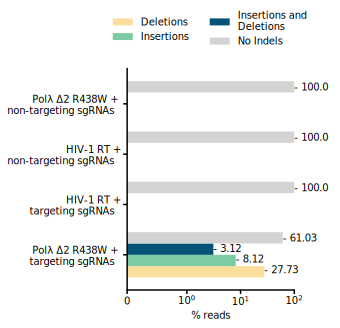

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 4))

to_plot_rescaled = indel_fract_dfs['1+B'].transpose().multiply(100)[::-1]
to_plot_rescaled.plot(kind='barh', legend=False, ax=ax, width=0.9,
               color = ['lightgray', '#045275', '#7ccba2', '#fcde9c'][::-1])
               #color = ['lightgray', 'purple', 'lightskyblue', 'tomato'][::-1])

ax.set_yticklabels([titles[x.get_text()].replace('+', '+\n') for x in ax.get_yticklabels()], size=10)
ax.set_xlabel('% reads', size=10)
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), frameon=False, title ='', prop={'size':10}, ncol=2)

for yi, i in enumerate(to_plot_rescaled.index):
    for xc, c in enumerate(to_plot_rescaled.columns):
        y = yi+(xc-1.5)*0.21-0.05
        x = to_plot_rescaled.loc[i, c]
        if round(to_plot_rescaled.loc[i, c], 2) > 0:
            ax.text(x, y, '-  {}'.format(round(to_plot_rescaled.loc[i, c], 2)))

ax.set_xlim(0,100)
ax.set_xscale('symlog', linthresh=1)
# #ax.set_yscale('symlog', linthresh=0.01)
# for y in ax.get_yticklabels():
#     y.set_size(12)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(width=1.5, length=4)

plt.show()

## Supplementary figures

In [94]:
UMI_depth = 1

In [95]:
upstream_window = 5

In [96]:
data_in_window = {'1+B':{}}
for f in raw_pileup_data:
    nick_1 = int(nick_sites['SPIKE-EVO-1-B_S12']['1']+0.5)
    nick_B = int(nick_sites['SPIKE-EVO-1-B_S12']['B']+0.5)
    data_in_window['1+B'][f] = data_by_UMI_depth[UMI_depth][f][
        nick_1-upstream_window:nick_B+upstream_window]['af']

In [97]:
nick_B+upstream_window - (nick_1-upstream_window)

46

In [98]:
data_by_UMI_depth[UMI_depth].keys()

dict_keys(['SPIKE-RT-EMPTY_S9', 'SPIKE-RT-1-B_S10', 'SPIKE-EVO-EMPTY_S11', 'SPIKE-EVO-1-B_S12'])

In [99]:
data_in_window = {g:pd.DataFrame(data_in_window[g]) for g in data_in_window}

In [100]:
data_in_window['1+B'].shape[0]

46

In [101]:
data_in_window_reshaped = pd.concat([data_in_window[g].melt().assign(guide=[g]*data_in_window[g].melt().shape[0]) for g in data_in_window])

In [102]:
data_in_window_reshaped.columns = ['Sample', 'AF', 'Guide']

In [103]:
data_in_window_reshaped.to_csv('SPIKE_pileup_raw_AF_melted.tsv', sep='\t', index=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


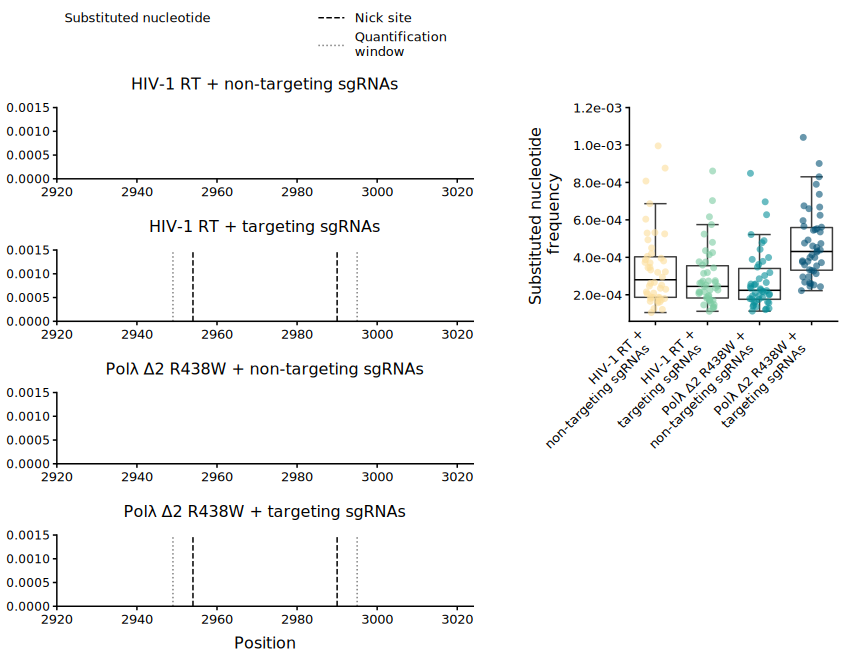

In [106]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(14, 9),
                        gridspec_kw={'width_ratios':[2,1], 'height_ratios':[1,1,1,1]})

gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0:4, 1]:
    ax.remove()
axbig = fig.add_subplot(gs[0:2, 1])


font_size = 16
lgnd_size = 13

########################################################################################################
# RAW PILEUP

ax = axs[0:4, 0]

af_to_plot = {f:make_af_to_plot(raw_pileup_data[f]) for f in raw_pileup_data}
for n,f in enumerate(raw_pileup_data):
    # af_to_plot[f][['A', 'G', 'T', 'C']].plot(kind='bar', stacked=True, ax=ax[n], legend=False, width=1,
    #                                          #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
    #                                          #color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
    #                                          #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
    #                                          color = ['#33a02c', '#1f78b4', '#b2df8a', '#a6cee3']) # blue and green
    ymax = 0.0015
    ax[n].set_ylim(0, ymax)
    ax[n].set_xlim(2954-34, 2990+34)
    ax[n].set_xticks([i for i in range(2954-34, 2990+34, 20)])
    ax[n].set_xticklabels([i for i in range(2954-34, 2990+34, 20)], size=lgnd_size, rotation=0)
    ax[n].set_yticks([0,0.5e-3, 1e-3, 1.5e-3])
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(titles[f], size=font_size, pad=18)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    #ax[n].set_ylabel('N', size=2, labelpad=20, color='white')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        nick_l = ax[n].vlines(nick, 0, ymax, color='k', linestyle='--', label='Nick site')
        if 'B' not in guide_names:
            ax[n].vlines(nick-upstream_window, 0, ymax, color='gray', linestyle='dotted')
            ax[n].vlines(nick+downstream_window, 0, ymax, color='gray', linestyle='dotted')
        else:
            if guide_name=='B':
                qw_l = ax[n].vlines(nick+upstream_window, 0, ymax, color='gray', linestyle='dotted', label='Quantification\nwindow')
            else:
                ax[n].vlines(nick-upstream_window, 0, ymax, color='gray', linestyle='dotted')

lgd = ax[0].legend(loc='upper right', bbox_to_anchor=(0.4, 2.5),
                title ='Substituted nucleotide', prop={'size':lgnd_size}, ncol=4, frameon=False)
plt.setp(lgd.get_title(),fontsize=str(lgnd_size))

ax[1].legend(handles = [nick_l, qw_l], loc='upper left', bbox_to_anchor=(0.6, 4.5), prop={'size':lgnd_size}, ncol=1, frameon=False)

ax[-1].set_xlabel('Position', size=font_size, labelpad=10)

#############################################################################################ààà
# BOXPLOT

ax = axbig
data = data_in_window[guide]
sns.boxplot(data=data, ax=ax, color='white', flierprops={'alpha':0}, medianprops={'color':'k'}, linewidth=1.5)
sns.stripplot(data=data, ax=ax, palette=colors_bxp, alpha=0.6, jitter=0.2, size=7)
sns.despine()
ax.set_title('Guide {}'.format(guide))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([titles[x].replace('+', '+\n') for x in data.columns])
#ax.set_yscale('symlog', linthresh=1e-4)
ax.set_ylim(top=1.2e-3)
ax.set_title('')
for x in ax.get_xticklabels():
    x.set_rotation(45)
    x.set_ha('right')
    x.set_size(lgnd_size)
    
for y in ax.get_yticklabels():
    y.set_size(lgnd_size)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(width=1.5, length=4)
ax.set_ylabel('Substituted nucleotide\nfrequency', size=font_size, labelpad=10)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))

plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

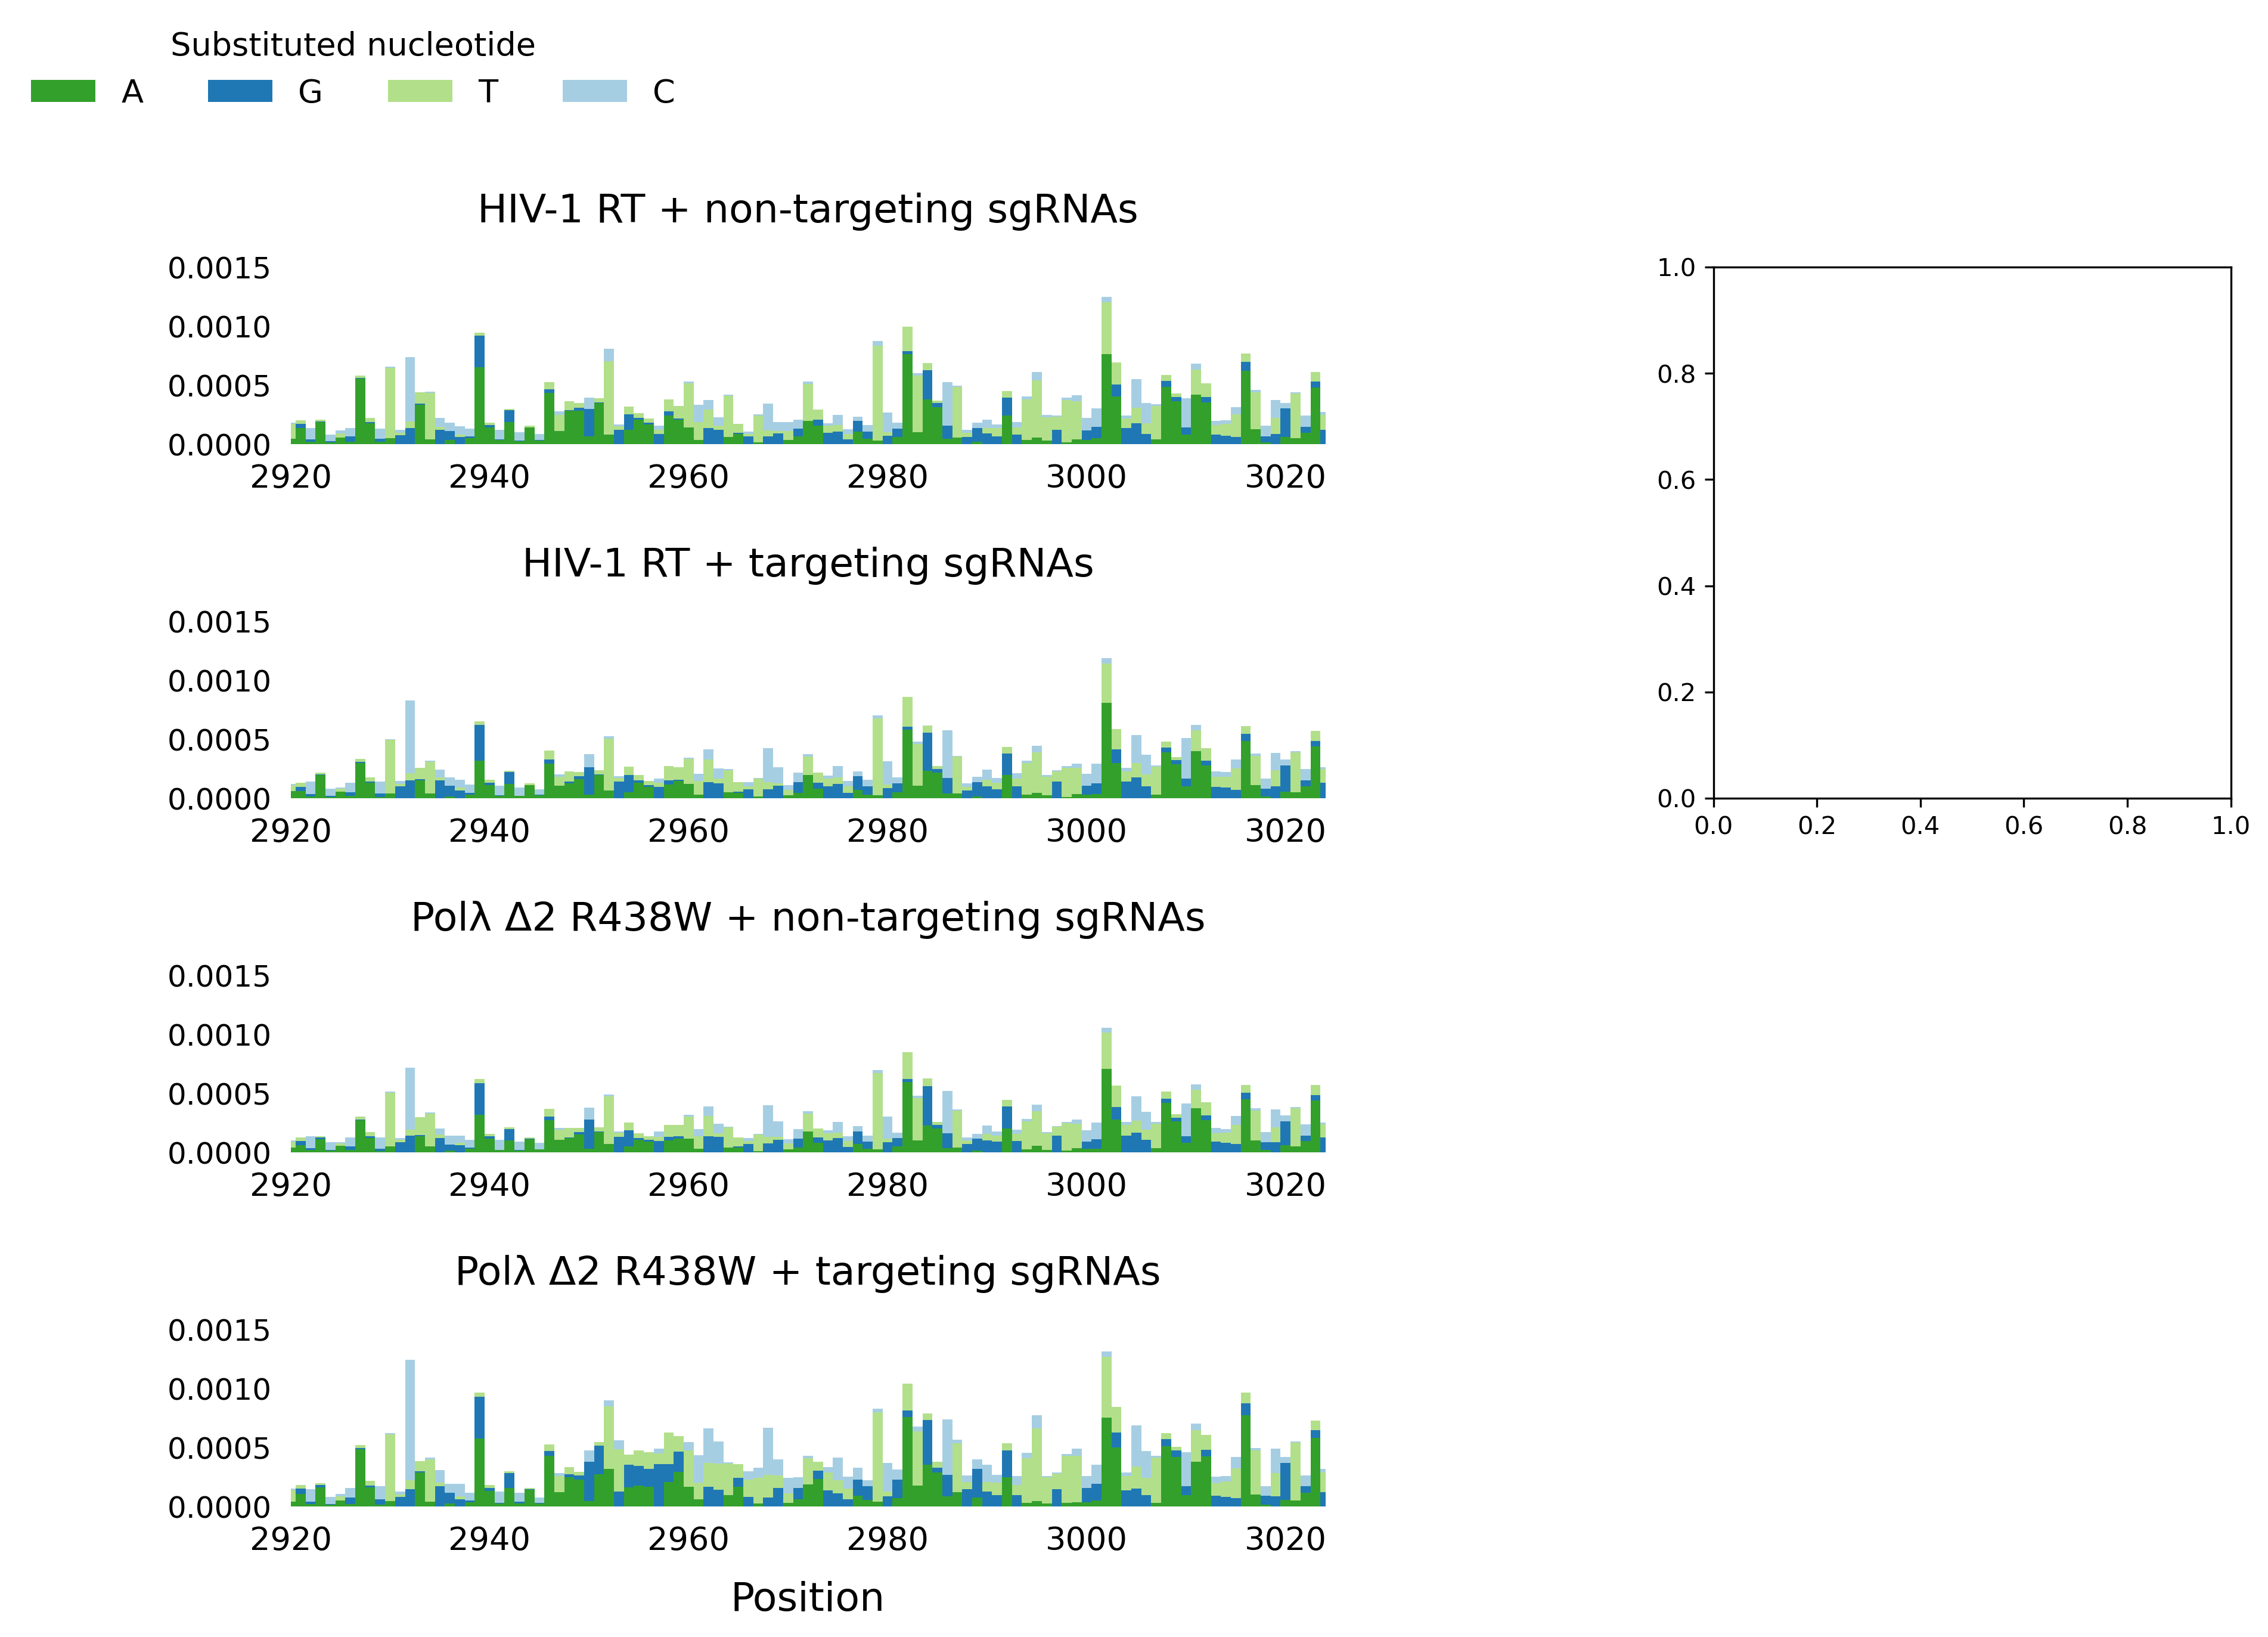

In [111]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(14, 9),
                        gridspec_kw={'width_ratios':[2,1], 'height_ratios':[1,1,1,1]})

gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0:4, 1]:
    ax.remove()
axbig = fig.add_subplot(gs[0:2, 1])


font_size = 16
lgnd_size = 13

########################################################################################################
# RAW PILEUP

ax = axs[0:4, 0]

af_to_plot = {f:make_af_to_plot(raw_pileup_data[f]) for f in raw_pileup_data}
for n,f in enumerate(raw_pileup_data):
    af_to_plot[f][['A', 'G', 'T', 'C']].plot(kind='bar', stacked=True, ax=ax[n], legend=False, width=1,
                                             #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
                                             #color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
                                             #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
                                             color = ['#33a02c', '#1f78b4', '#b2df8a', '#a6cee3']) # blue and green
    ymax = 0.0015
    ax[n].set_ylim(0, ymax)
    ax[n].set_xlim(2954-34, 2990+34)
    ax[n].set_xticks([i for i in range(2954-34, 2990+34, 20)])
    ax[n].set_xticklabels([i for i in range(2954-34, 2990+34, 20)], size=lgnd_size, rotation=0)
    ax[n].set_yticks([0,0.5e-3, 1e-3, 1.5e-3])
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(titles[f], size=font_size, pad=18)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_visible(False)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_visible(False)
    ax[n].tick_params(width=0, length=4)
    #ax[n].set_ylabel('N', size=2, labelpad=20, color='white')
    # guide_names = guides_by_sample[f]
    # for guide_name in guide_names:
    #     nick = nick_sites[f][guide_name]
    #     nick_l = ax[n].vlines(nick, 0, ymax, color='k', linestyle='--', label='Nick site')
    #     if 'B' not in guide_names:
    #         ax[n].vlines(nick-upstream_window, 0, ymax, color='gray', linestyle='dotted')
    #         ax[n].vlines(nick+downstream_window, 0, ymax, color='gray', linestyle='dotted')
    #     else:
    #         if guide_name=='B':
    #             qw_l = ax[n].vlines(nick+upstream_window, 0, ymax, color='gray', linestyle='dotted', label='Quantification\nwindow')
    #         else:
    #             ax[n].vlines(nick-upstream_window, 0, ymax, color='gray', linestyle='dotted')

lgd = ax[0].legend(loc='upper right', bbox_to_anchor=(0.4, 2.5),
                title ='Substituted nucleotide', prop={'size':lgnd_size}, ncol=4, frameon=False)
plt.setp(lgd.get_title(),fontsize=str(lgnd_size))

#ax[1].legend(handles = [nick_l, qw_l], loc='upper left', bbox_to_anchor=(0.6, 4.5), prop={'size':lgnd_size}, ncol=1, frameon=False)

ax[-1].set_xlabel('Position', size=font_size, labelpad=10)

#############################################################################################ààà
# BOXPLOT

# ax = axbig
# data = data_in_window[guide]
# sns.boxplot(data=data, ax=ax, color='white', flierprops={'alpha':0}, medianprops={'color':'k'}, linewidth=1.5)
# sns.stripplot(data=data, ax=ax, palette=colors_bxp, alpha=0.6, jitter=0.2, size=7)
# sns.despine()
# ax.set_title('Guide {}'.format(guide))
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels([titles[x].replace('+', '+\n') for x in data.columns])
# #ax.set_yscale('symlog', linthresh=1e-4)
# ax.set_ylim(top=1.2e-3)
# ax.set_title('')
# for x in ax.get_xticklabels():
#     x.set_rotation(45)
#     x.set_ha('right')
#     x.set_size(lgnd_size)
    
# for y in ax.get_yticklabels():
#     y.set_size(lgnd_size)
# ax.spines['bottom'].set_linewidth(1.5)
# ax.spines['left'].set_linewidth(1.5)
# ax.tick_params(width=1.5, length=4)
# ax.set_ylabel('Substituted nucleotide\nfrequency', size=font_size, labelpad=10)
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))

plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

## Supplementary figure 7

In [68]:
af_to_plot = {f:make_af_to_plot(indel_pileup_data[f]) for f in indel_pileup_data}

In [69]:
titles = {
    'SPIKE-RT-EMPTY_S9':'HIV-1 RT + non-targeting sgRNAs',
    'SPIKE-RT-1-B_S10': 'HIV-1 RT + targeting sgRNAs',
    'SPIKE-EVO-EMPTY_S11': 'Polλ Δ2 R438W + non-targeting sgRNAs',
    'SPIKE-EVO-1-B_S12': 'Polλ Δ2 R438W + targeting sgRNAs'
}

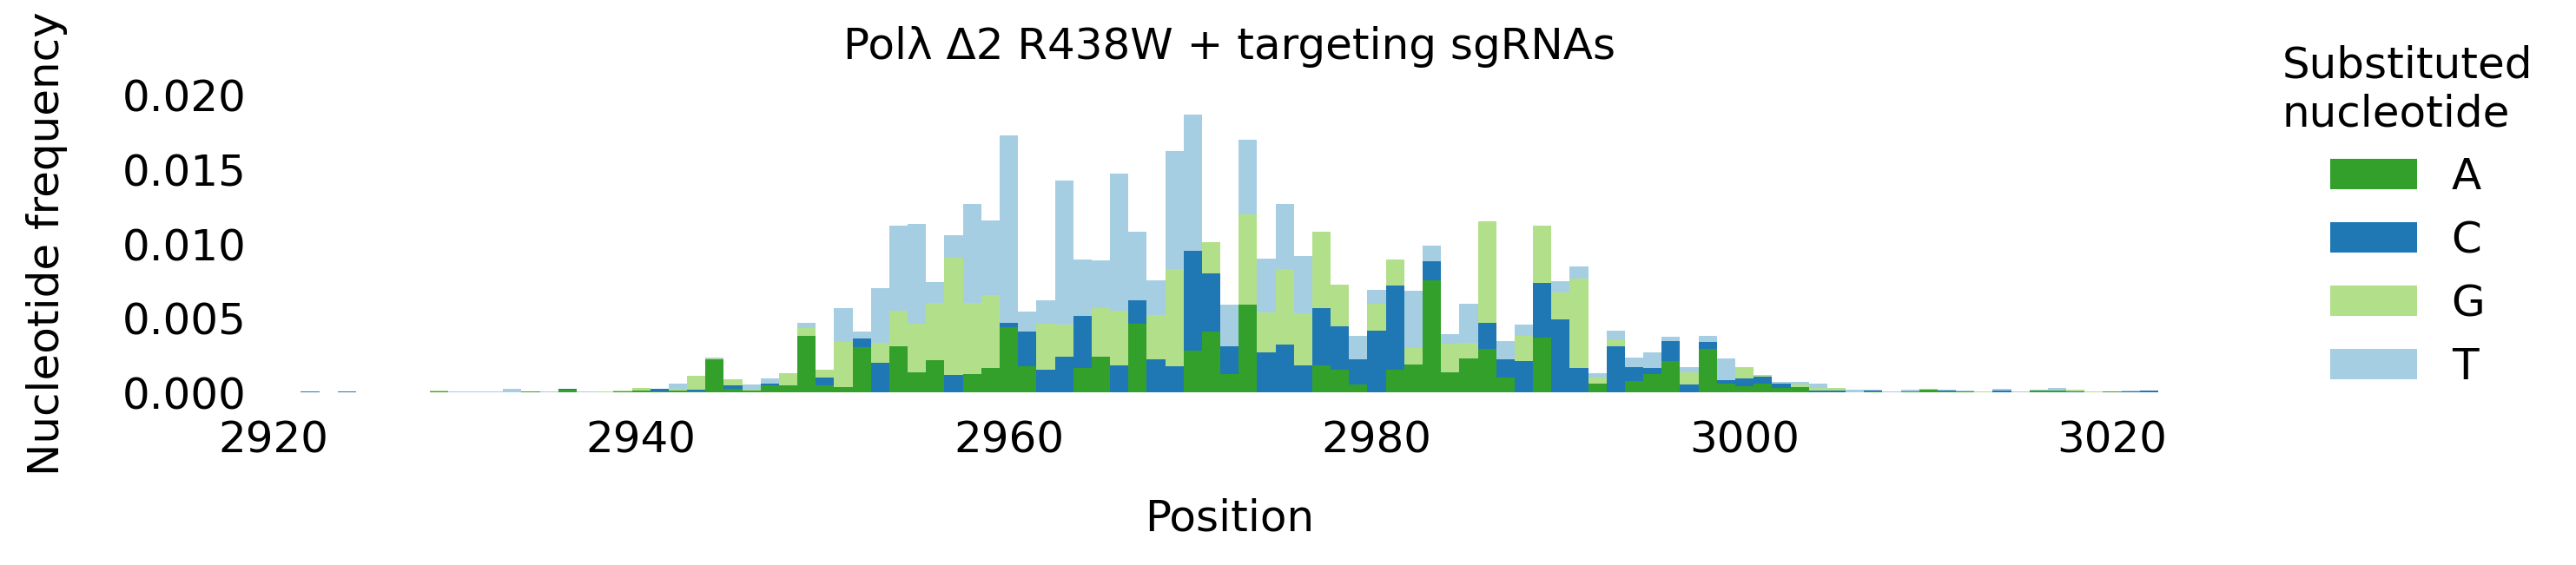

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 2.5))

for n,f in enumerate(['SPIKE-EVO-1-B_S12']):
    af_to_plot[f][['A', 'C', 'G', 'T']].plot(kind='bar', stacked=True, ax=ax, legend=False, width=1,
                                             #color = ['#f8766d', '#7cae00', '#00bfc4','#c77cff']) original
                                             #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
                                             color = ['#33a02c', '#1f78b4', '#b2df8a', '#a6cee3']) # green and blue
                                             #color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
                                             #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
    ymax = {'SPIKE-EVO-1-B_S12':0.02}
    ax.set_ylim(0, ymax[f])
    ax.set_xlim(2954-34, 2990+34)
    ax.set_xticks([i for i in range(2954-34, 2990+34, 20)])
    ax.set_xticklabels([i for i in range(2954-34, 2990+34, 20)], size=12, rotation=0)
    for y in ax.get_yticklabels():
        y.set_size(12)
    ax.set_title(titles[f], size=12, pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(False)
    ax.tick_params(width=0, length=4)
    ax.set_ylabel('Nucleotide frequency', size=12, labelpad=15, color='k')
    guide_names = guides_by_sample[f]
    # for guide_name in guide_names:
    #     nick = nick_sites[f][guide_name]
    #     if guide_name=='B':
    #         nick_l = ax.vlines(nick, 0, ymax[f], color='k', linestyle='--', label='Nick site')
    #     else:
    #         ax.vlines(nick, 0, ymax[f], color='k', linestyle='--')
        # if 'B' not in guide_names:
        #     ax.vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        #     ax.vlines(nick+downstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        # else:
        #     if guide_name=='B':
        #         qw_l = ax.vlines(nick+upstream_window, 0, ymax[f], color='gray', linestyle='dotted', label='Quantification\nwindow')
        #     else:
        #         ax.vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,4,0]
lgd = ax.legend(handles, labels, loc='upper left',
                bbox_to_anchor=(1.03, 1.3), frameon=False, title ='Substituted\nnucleotide', prop = 
                {'size':12}, ncol=1)
plt.setp(lgd.get_title(),fontsize='12')
ax.set_xlabel('Position', size=12, labelpad=10)
    
plt.tight_layout()
plt.show()

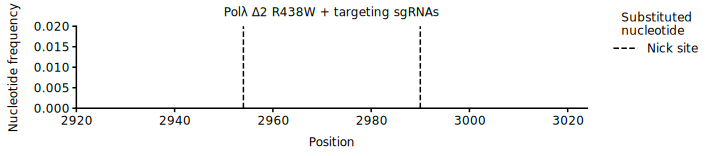

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 2.5))

for n,f in enumerate(['SPIKE-EVO-1-B_S12']):
#    af_to_plot[f][['A', 'C', 'G', 'T']].plot(kind='bar', stacked=True, ax=ax, legend=False, width=1,
                                             #color = ['#f8766d', '#7cae00', '#00bfc4','#c77cff']) original
                                             #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
                                             #color = ['#33a02c', '#1f78b4', '#b2df8a', '#a6cee3']) # green and blue
                                             #color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
                                             #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
    ymax = {'SPIKE-EVO-1-B_S12':0.02}
    ax.set_ylim(0, ymax[f])
    ax.set_xlim(2954-34, 2990+34)
    ax.set_xticks([i for i in range(2954-34, 2990+34, 20)])
    ax.set_xticklabels([i for i in range(2954-34, 2990+34, 20)], size=12, rotation=0)
    for y in ax.get_yticklabels():
        y.set_size(12)
    ax.set_title(titles[f], size=12, pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.tick_params(width=1.5, length=4)
    ax.set_ylabel('Nucleotide frequency', size=12, labelpad=15, color='k')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        if guide_name=='B':
            nick_l = ax.vlines(nick, 0, ymax[f], color='k', linestyle='--', label='Nick site')
        else:
            ax.vlines(nick, 0, ymax[f], color='k', linestyle='--')
        # if 'B' not in guide_names:
        #     ax.vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        #     ax.vlines(nick+downstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        # else:
        #     if guide_name=='B':
        #         qw_l = ax.vlines(nick+upstream_window, 0, ymax[f], color='gray', linestyle='dotted', label='Quantification\nwindow')
        #     else:
        #         ax.vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')

handles, labels = plt.gca().get_legend_handles_labels()
#order = [1,2,3,4,0]
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.03, 1.3),
                frameon=False, title ='Substituted\nnucleotide', prop={'size':12}, ncol=1)
plt.setp(lgd.get_title(),fontsize='12')
ax.set_xlabel('Position', size=12, labelpad=10)
    
plt.tight_layout()
plt.show()

In [78]:
window_start = int(nick_sites['SPIKE-EVO-1-B_S12']['1']+0.5) - upstream_window
window_end = int(nick_sites['SPIKE-EVO-1-B_S12']['B']+0.5) + upstream_window
alt_base_count = {}
bases = ['A', 'C', 'G', 'T']
for f in indel_pileup_data:
    alt_base_count[f] = {'og_'+b:{b2:0 for b2 in bases if b2!=b} for b in bases}
    for i in range(window_start, window_end):
            ref = indel_pileup_data[f].loc[i, 'ref']
            for b in bases:
                if b!=ref:
                    alt_base_count[f]['og_'+ref][b] += indel_pileup_data[f].loc[i, b]

In [79]:
alt_base_count = {f:pd.DataFrame(alt_base_count[f]).transpose().fillna(0)[
    ['A', 'C', 'G', 'T']] for f in alt_base_count}

In [81]:
alt_base_count['SPIKE-EVO-1-B_S12'].sum().sum()

28194.0

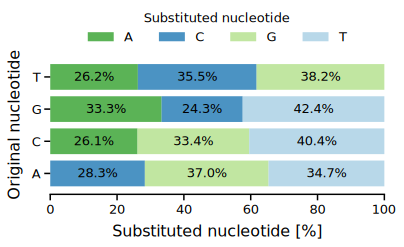

In [84]:
name = 'SPIKE-EVO-1-B_S12'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2.5))
perc = alt_base_count[name].divide(alt_base_count[name].sum(axis=1), axis=0).multiply(100)
perc_cumsum = perc.apply(np.cumsum, axis=1)

ax = perc.plot(kind='barh', stacked=True, width=0.8, ax=ax, legend=False, alpha=0.8,
               #color = ['#fdae61', '#d7191c', '#abd9e9', '#2c7bb6']) # red and blue
               #color = ['#80cdc1', '#018571', '#dfc27d', '#a6611a']) # orange and green
               color = ['#33a02c', '#1f78b4', '#b2df8a', '#a6cee3']) # blue and green
               #color = ['#fdb863', '#e66101', '#b2abd2', '#5e3c99']) # orange and purple
               #color = ['#fcde9c', '#7ccba2', '#089099', '#045275']) # green gradient
               #color = ['#fcde9c', '#f0746e', '#dc3977', '#7c1d6f']) # red gradient
#ax.set_title('Base modification types', size=12, pad=8)
ax.set_xlabel('Substituted nucleotide [%]', size=16, labelpad=8)

lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), frameon=False,
                title ='Substituted nucleotide', prop={'size':13}, ncol=4)
plt.setp(lgd.get_title(),fontsize='13')
ax.set_yticklabels([y.split('_')[1] for y in perc.index])

for y in ax.get_yticklabels():
    y.set_size(13)
for x in ax.get_xticklabels():
    x.set_size(13)
    x.set_rotation(0)
    
for jy,j in enumerate(perc.index):
    for ix,i in enumerate(perc.columns):
        if perc.loc[j, i]>0:
            x_base = perc_cumsum.loc[j].iloc[ix-1] if ix>0 else 0
            x = (perc_cumsum.loc[j, i]+x_base)/2
            ax.text(x, jy-0.12, '{:.1f}%'.format(perc.loc[j, i]), color='k', horizontalalignment='center',
                   size=13)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)

ax.tick_params(width=1.5, length=6)
    
ax.set_xlim(0,100)    
ax.set_ylabel('Original nucleotide', size=16, labelpad=8)
#plt.tight_layout()
plt.show()